In [1]:
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
import pandas as pd
import math
import matplotlib.pyplot as plt

class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()

        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()


In [2]:
# Retrieval of v_max. Note: the median of the top 10 velos is calculated per ride to avoid outliers.

conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
conn.autocommit = True

register(conn)
cur = conn.cursor()

cur.execute("""SELECT filename, PERCENTILE_CONT(0.5) WITHIN GROUP(ORDER BY foo.velo) FROM(
                SELECT clean.filename,
                       clean.velo,
                       rank() OVER (
                           PARTITION BY filename
                           ORDER BY velo DESC
                           )
                FROM
                     (SELECT flat.filename filename,
                             flat.velo velo
                      FROM
                           (SELECT ride.filename,
                                   unnest(ride.velos) velo
                           FROM ride) as flat
                      WHERE NULLIF(flat.velo, 'NaN') IS NOT NULL) as clean) as foo 
                WHERE velo < 14 AND velo > 0.1 AND foo.rank <= 10 GROUP BY filename""")

res = cur.fetchall()
df = pd.DataFrame(res, columns=['filename', 'max_v'])


0.12974499859962763
0.4340515752196492
KstestResult(statistic=0.006936641676685729, pvalue=0.08757738010121574)
-0.821035845534201 2.6105160272503314 5.998944974969769 3.7292462262638044
4.802450933506867
10.069314464746522


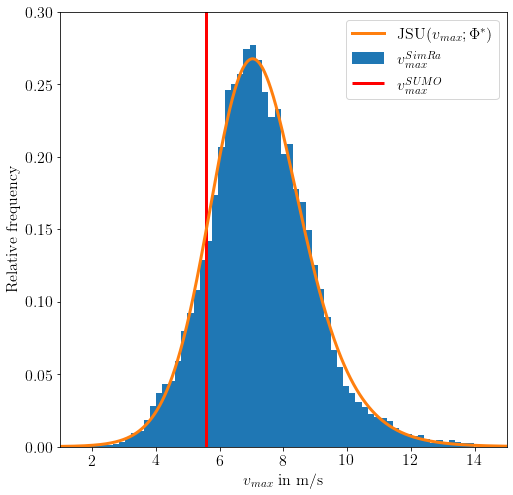

In [5]:
import scipy.stats
import numpy as np
from matplotlib import rc


plt.figure(figsize=(8,8))
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
rc('text', usetex=True)
plt.hist(df.max_v, bins=65, density=True, label=r'$v_{max}^{SimRa}$')

a, b, loc, scale = scipy.stats.johnsonsu.fit(df.max_v)
x = np.linspace(0, 16, 1000)
y = scipy.stats.johnsonsu.pdf(x, a, b, loc, scale)
plt.plot(x, y, linewidth=3, label='JSU(' + r'$v_{max}; \Phi^*$' + ')')
plt.xlabel(r'$v_{max}$ in m/s')
plt.ylabel('Relative frequency')
plt.vlines(5.56, 0, 4, colors='r', linewidth=3, label=r'$v_{max}^{SUMO}$')
plt.xlim(1, 15)
plt.ylim(0, 0.3)

plt.legend()
plt.savefig("images/velo_max_v_avg_n.png", dpi=300, bbox_inches='tight')

print(scipy.stats.johnsonsu.cdf(5.56, a, b, loc, scale))
print(scipy.stats.johnsonsu.cdf(25/3.6, a, b, loc, scale)) # 

print(scipy.stats.kstest(df.max_v, 'johnsonsu', args=(a, b, loc, scale)))
print(a, b, loc, scale)
print(scipy.stats.johnsonsu.ppf(0.05, a, b, loc, scale))
print(scipy.stats.johnsonsu.ppf(0.95, a, b, loc, scale))


In [4]:
# Find best distribution for v_max

list_of_dists = ['powernorm','norm','exponnorm','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

results=[]
for i in list_of_dists:
    dist = getattr(scipy.stats, i)
    param = dist.fit(df.max_v)
    a = scipy.stats.kstest(df.max_v, i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:781: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/home/kons/GIT/ma/ma_env/l

/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 36.59117175767605.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 37.38800131337338.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 35.81733794783898.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 36.63165974774708.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2

/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 47.88025019116277.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 47.87429035654967.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 47.8890269281509.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2961: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 47.881208371105636.
  RuntimeWarning)
/home/kons/GIT/ma/ma_env/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2

KeyboardInterrupt: 

0.10081143294387973
0.11132653346896179


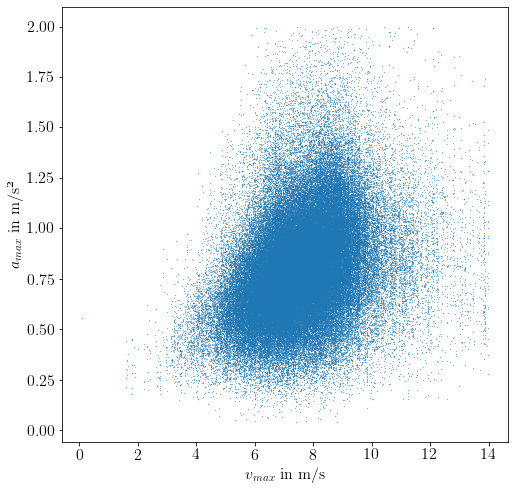

In [6]:
# Show correlation between a_max and v_max (v_max = again Median of top 10 per ride)

from scipy.stats import linregress


with DatabaseConnection() as cur:
    cur.execute("""
    SELECT a.filename, avg_velo, max_a
FROM (SELECT filename, avg(foo.velo) avg_velo
      FROM (
               SELECT clean.filename,
                      clean.velo,
                      rank() OVER (
                          PARTITION BY filename
                          ORDER BY velo DESC
                          )
               FROM (SELECT flat.filename filename,
                            flat.velo     velo
                     FROM (SELECT ride.filename,
                                  unnest(ride.velos) velo
                           FROM ride) as flat
                     WHERE NULLIF(flat.velo, 'NaN') IS NOT NULL) as clean) as foo
      WHERE velo < 14
        AND foo.rank <= 10
      GROUP BY filename) a
         INNER JOIN
     (select accels.filename, max(accel) max_a
      from accels
      where type = 'a'
      group by seg_id, accels.filename
      having max(accel) < 2
         and sum(dist) < 350
         and sum(dist) > 20
         and min(velo) < 1) b
     ON a.filename = b.filename
    """)
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'max_v', 'max_a'])
    df['ln_max_v'] = df.apply(lambda x: math.log(x['max_v']), axis = 1) 
    df['ln_max_a'] = df.apply(lambda x: math.log(x['max_a']), axis = 1) 
    
    
    plt.figure(figsize=(8,8))

    plt.scatter(df.max_v, df.max_a, marker='.', s=0.2,)
    plt.xlabel(r'$v_{max}$ in m/s')
    plt.ylabel(r'$a_{max}$ in m/s²')

    plt.savefig("images/acc_vs_velo.png", dpi=300, bbox_inches='tight')
    
slope, intercept, r_value, p_value, std_err = linregress(df.max_v, df.max_a)
print(r_value**2)

slope, intercept, r_value, p_value, std_err = linregress(df.ln_max_v, df.ln_max_a)
print(r_value**2)

